In [56]:
#### Notebook 2019-8-11 6:16pm CT by Joshua Yao-Yu Lin


# import of standard python libraries
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from  torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
import sys
import argparse
from tqdm import tqdm
import pandas as pd
import gc
import scipy.ndimage
import datetime
#sys.path.insert(0, '../lenstronomy/lenstronomy/')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Util import param_util
from lenstronomy.Util import simulation_util# as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

In [57]:
root_folder = "/media/joshua/HDD_fun2/time_delay_challenge/Second_sims/"
train_folder = "train/"
test_folder = "test/"
train_data = pd.read_csv(root_folder + train_folder + "lens_info.csv")
test_data = pd.read_csv(root_folder + test_folder + "lens_info.csv")
files = os.listdir(EHT_test_path)
loaded_model_path = './saved_model/2019-08-06power_law_pred_resnet18.mdl'


if os.path.exists(loaded_model_path):
    net = torch.load(loaded_model_path)
    print('loaded mdl！')
else:
    print('No model to load. Should stop!')
    
print(os.getcwd()) 


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
data_transform = transforms.Compose([
            transforms.ToTensor(), # scale to [0,1] and convert to tensor
            normalize,
            ])
target_transform = torch.Tensor

loaded mdl！
/home/joshua/Documents/git_work_zone/time_delay_challenge


In [58]:
glo_batch_size = 1
test_num_batch = 1



class DeepLenstronomyDataset(Dataset): # torch.utils.data.Dataset
    def __init__(self, root_dir, train=True, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set
        self.train_folder = 'train'#'data_train'
        self.test_folder = 'test'#'data_test'
        #self.df = pd.read_csv('../input/clean-full-train/clean_full_data.csv') #+ '/clean_full_data.csv')


        if self.train:
            self.path = os.path.join(self.root_dir, self.train_folder)
            self.df = pd.read_csv(self.path + '/lens_info.csv')


            #self.length = TRAINING_SAMPLES
        else:
            self.path = os.path.join(self.root_dir, self.test_folder)
            self.df = pd.read_csv(self.path + '/lens_info.csv')
            #self.length = TESTING_SAMPLES

    def __getitem__(self, index):
        #   gamma  center_x  center_y        e1        e2  source_x  source_y  gamma_ext  psi_ext
        #print(self.df['name'].iloc[[index]])
        name = self.df['name'].iloc[[index]]
        theta_E = self.df['theta_E'].iloc[[index]]
        gamma = self.df['gamma'].iloc[[index]]
        center_x = self.df['center_x'].iloc[[index]]
        center_y = self.df['center_y'].iloc[[index]]
        e1 = self.df['e1'].iloc[[index]]
        e2 = self.df['e2'].iloc[[index]]
        source_x = self.df['source_x'].iloc[[index]]
        source_y = self.df['source_y'].iloc[[index]]
        gamma_ext = self.df['gamma_ext'].iloc[[index]]
        psi_ext = self.df['psi_ext'].iloc[[index]]
        img_path = self.path + "/" + str(name.values[0]) + ".npy"
        img = np.load(img_path)
        img = scipy.ndimage.zoom(img, 224/100, order=1)
        image = np.zeros((3, 224, 224))
        for i in range(3):
            image[i, :, :] += img
        return image, theta_E.values, gamma.values, center_x.values, center_y.values, e1.values, e2.values, source_x.values, source_y.values, gamma_ext.values, psi_ext.values


    def __len__(self):
        return self.df.shape[0]
    
train_loader = torch.utils.data.DataLoader(DeepLenstronomyDataset(root_folder, train=True, transform=data_transform, target_transform=target_transform),
                    batch_size = glo_batch_size, shuffle = True
                    )

test_loader = torch.utils.data.DataLoader(DeepLenstronomyDataset(root_folder, train=False, transform=data_transform, target_transform=target_transform),
            batch_size = glo_batch_size, shuffle = True
            )

fermat_pot [-1.20192358 -1.17036548 -1.38349303 -1.57597606]


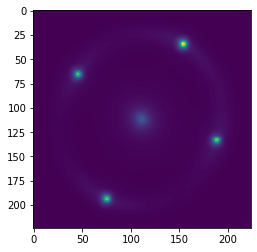

fermat_pot [-0.59887565 -0.54351804 -0.90503571 -1.08204856]


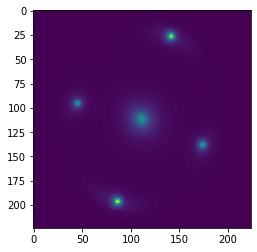

fermat_pot [-0.82834305 -0.74550062 -1.08607101 -1.34249148]


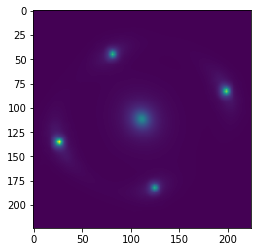

fermat_pot [-0.90517912 -0.88930054 -1.30810177 -1.37590488]


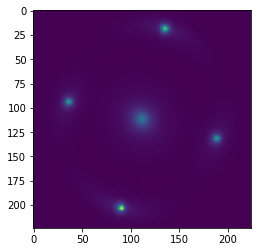

fermat_pot [-0.81290185 -0.66395854 -1.12267502 -1.21753955]


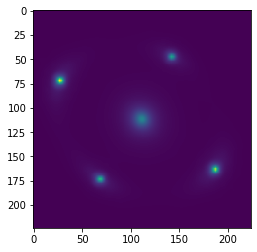

fermat_pot [-1.06830674 -0.89259439 -1.23078527 -1.27530375]


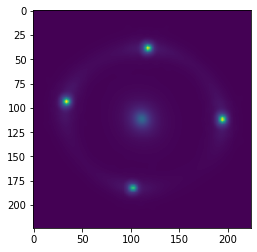

fermat_pot [-1.00921154 -0.94450865 -1.27081414 -1.35731581]


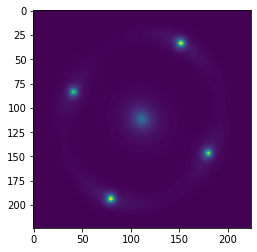

fermat_pot [-0.61099929 -0.395113   -0.82680135 -0.83635297]


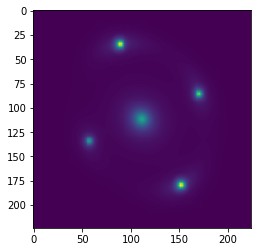

fermat_pot [-0.98077713 -0.94711043 -1.27914171 -1.29068847]


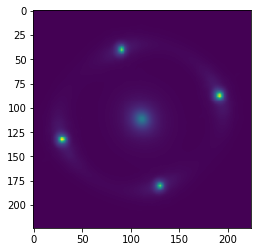

fermat_pot [-1.02133186 -0.97643982 -1.32338154 -1.35525338]


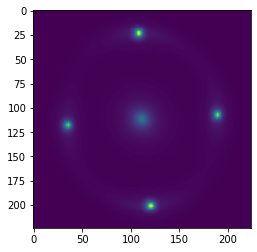

fermat_pot [-1.30830561 -1.28628616 -1.52619777 -1.75465043]


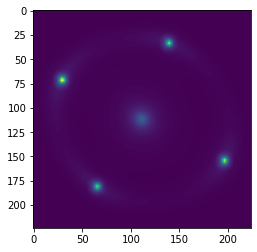

fermat_pot [-1.02058726 -1.01452737 -1.32984427 -1.60794602]


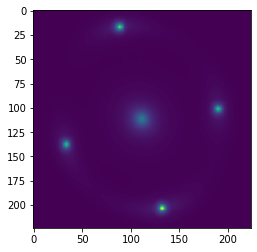

fermat_pot [-0.76291202 -0.65049491 -1.02756082 -1.11737187]


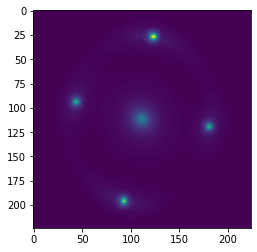

fermat_pot [-1.07296181 -0.95551089 -1.34764733 -1.51239327]


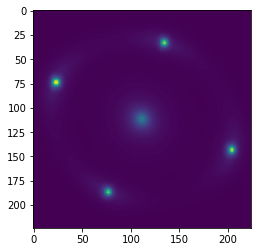

fermat_pot [-0.57898537 -0.51011813 -0.76507452 -0.93455652]


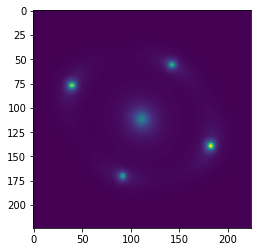

fermat_pot [-1.23808985 -1.14396826 -1.43331981 -1.46728894]


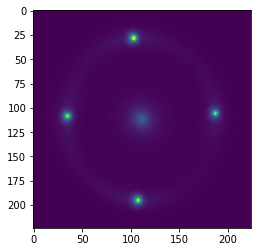

fermat_pot [-1.13502189 -1.11319246 -1.30264492 -1.37772156]


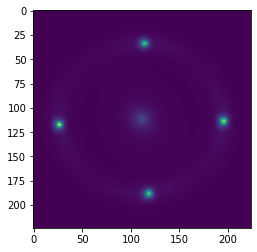

fermat_pot [-0.97053248 -0.86611861 -1.42242411 -1.42704141]


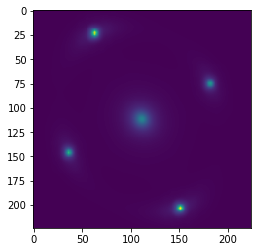

fermat_pot [-0.75905511 -0.69600357 -0.82192363 -1.01020659]


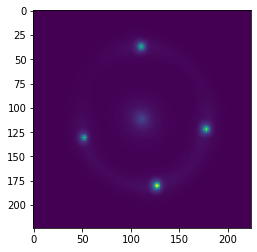

fermat_pot [-1.17065711 -1.10317926 -1.45606156 -1.50787314]


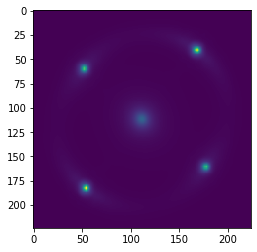

fermat_pot [-1.07748761 -1.00644694 -1.20987561 -1.38809383]


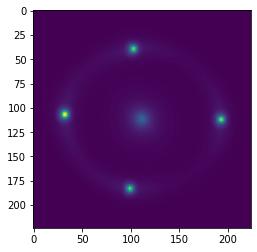

fermat_pot [-1.05463071 -0.92268911 -1.16137378 -1.28760537]


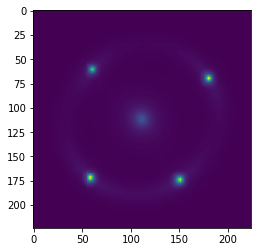

In [61]:


lens_model_list = ['SPEP', 'SHEAR_GAMMA_PSI']
point_source_list = ['SOURCE_POSITION']

lens_model_class = LensModel(lens_model_list=lens_model_list)
kwargs_model = {'lens_model_list': lens_model_list,
                'point_source_model_list': point_source_list
                 }
lensAnalysis = LensAnalysis(kwargs_model)


deltaPix = 0.05 
numPix = 100

net.cuda()
net.eval()

for batch_idx, (data, theta_E, gamma, center_x, center_y, e1, e2, source_x, source_y, gamma_ext, psi_ext) in enumerate(test_loader):
    img = data
    data = data.float()# theta_E.float(), gamma.float(), center_x.float(), center_y.float(), e1.float(), e2.float(), source_x.float(), source_y.float(), gamma_ext.float(), psi_ext.float()
    data= Variable(data).cuda()# Variable(theta_E).cuda(), Variable(gamma).cuda(), Variable(center_x).cuda(), Variable(center_y).cuda(), Variable(e1).cuda(), Variable(e2).cuda(), Variable(source_x).cuda(), Variable(source_y).cuda(), Variable(gamma_ext).cuda(), Variable(psi_ext).cuda()
    lensEquationSolver = LensEquationSolver(lens_model_class)
    
    source_x = source_x.cpu().numpy()[0][0]
    source_y = source_y.cpu().numpy()[0][0]
    
    
    
    #print("lens parameters: theta_E, e1, e2(ground trouth)", theta_E.cpu().numpy()[0][0], e1.cpu().numpy()[0][0], e2.cpu().numpy()[0][0])
    output = net(data)
    kwargs_spemd = {'theta_E':  output[0][0].detach().cpu().numpy(), 'gamma':output[0][1].detach().cpu().numpy(), 'e1':output[0][4].detach().cpu().numpy(), 'e2':output[0][5].detach().cpu().numpy(), 'center_x':output[0][2].detach().cpu().numpy(), 'center_y':output[0][3].detach().cpu().numpy()}
    kwargs_shear = {'gamma_ext': 0.00, 'psi_ext': -0.0}  # shear values to the source plane
    
    kwargs_lens = [kwargs_spemd, kwargs_shear]
    kwargs_ps = [{'ra_source':  output[0][6].detach().cpu().numpy(), 'dec_source': output[0][7].detach().cpu().numpy()}]
    
    
    x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4, min_distance=deltaPix, search_window=numPix * deltaPix)

    #print("source_x", source_x, source_y)
    #print("x_image",x_image, y_image)
    #print(kwargs_lens, kwargs_ps)
    
    ###### calculating Fermat potential
    fermat_pot = lens_model_class.fermat_potential(x_image, y_image, source_x, source_y, kwargs_lens = kwargs_lens)

    print("fermat_pot", fermat_pot)
    plt.imshow(data.cpu().numpy()[0,0,:,:])
    plt.show()

    if batch_idx > 20:
        break

In [60]:

# '''

# #####
# from lenstronomy.Analysis.lens_analysis import LensAnalysis
# lensAnalysis = LensAnalysis(kwargs_model)

# mcmc_new_list = []
# labels_new = [r"$\phi_{Fermat}$", r"$\gamma$", r"$\phi_{ext}$", r"$\gamma_{ext}$", r"$D_{\Delta t}$"]
# for i in range(len(samples_mcmc)):
#     # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
#     kwargs_result = param.args2kwargs(samples_mcmc[i])
#     D_dt = kwargs_result['kwargs_special']['D_dt']
#     fermat_pot = lensAnalysis.fermat_potential(kwargs_result['kwargs_lens'], kwargs_result['kwargs_ps'])
#     delta_fermat_12 = fermat_pot[0] - fermat_pot[2]
#     gamma = kwargs_result['kwargs_lens'][0]['gamma']
#     phi_ext, gamma_ext = kwargs_result['kwargs_lens'][1]['psi_ext'], kwargs_result['kwargs_lens'][1]['gamma_ext']
#     mcmc_new_list.append([delta_fermat_12, gamma, phi_ext, gamma_ext, D_dt])


# #####
# print(kwargs_result['kwargs_lens'], kwargs_result['kwargs_special'])
# print('fermat pot', fermat_pot)
# #####

# from lenstronomy.Cosmo.lens_cosmo import LensCosmo
# lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source)
# print(lensCosmo.D_dt)
# print(lensCosmo.h * lensCosmo.D_dt/kwargs_result['kwargs_special']['D_dt'])
# print("new H_0")
# '''
